# Opening DLIS Files and Extracting Data

[Digital Log Interchange Standard (DLIS) files](https://dlisio.readthedocs.io/en/latest/dlis/specification.html) are the industry standard for storing well log data, including raw and processed borehole image log data. They are a binary file format for data that stores various kinds of metadata about when, where and who collected the data. There are also lists of what data was collected and with what tools. They have a useful flexibility that can also make them a difficult file type to work with. This notebook is designed to help you to explore the contents of a DLIS file and extract the data you need. 

Typically, expensive specialist software is used to open and view a DLIS file. However, the methods in this notebook enable us to explore and extract the content of a DLIS file at no cost by using open-source library called [DLISio](https://dlisio.readthedocs.io/en/latest/index.html). While the focus here is on borehole image data, the same methods apply to other types of well log data stored as DLIS.

Helper functions and some methods used here come from [this example notebook](https://github.com/equinor/dlisio-notebooks/tree/master), as well as the [DLISio documentation](https://dlisio.readthedocs.io/en/latest/index.html).

If you have any questions about borehole image DLIS or this notebook, please email irene@cubicearth.nz

## DLIS File Jargon and Structure

The structure of a DLIS can be thought of as a hierarchical data storage system that includes various related metadata objects.

- A DLIS contains one or more _logical files_ that are like high-level folders. Commonly, separate logging runs in one well are stored as separate logical files in the same DLIS. For borehole image data, sometimes processed acoustic and microresistivity logs are delivered as septate logical files in a single DLIS. 

- Each logical file has an _origin_ that contains general information like when, where, and by whom the data was collected (metadata). Most logical files have a single origin. However, processed borehole image data may have more than one origin that includes the same information. If a logical file has more than one unique origin, then care should be taken to ensure data is associated with the correct origin.

- Each logical file has a set of _parameters_. These are metadata defined at the time of log acquisition. It includes constants relevant to the tool and logging conditions, such as logging datum, well construction, tool settings, etc.

- A _curve_ is a single, unique log (the data). For example: gamma, pad 1 azimuth, caliper 1, caliper 2, etc. A curve may have one dimension (a single value recorded per depth) or multiple dimensions (multiple values recorded per depth).

- Metadata about each curve is stored as a _channel_ object. This channel object contains information including the mnemonic (short name), long name, units, dimension, and associated frame. In this notebook, we make a table of these metadata to help us identify what data we want and the information needed to extract it.

- Curves and channels that share an index are collected together in a _frame_ object (index and metadata). The index is typically depth, but can be time for some data types. Frame objects include additional information like the spacing between data and direction of data acquisition. A frame typically includes curves (data) acquired in the same logging run.

- Each logical file has a _tool_ object (metadata) that describes the logging tool(s) used to acquire the data. In this notebook, we use the tool object to extract the _channels_ and _parameters_ associated with that tool.

- Each logical file has a _remarks_ object that stores comments made at the time of acquisition. These may include useful information about the logging conditions or data quality. 




In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import logging

import dlisio
from dlisio import dlis

## 1. Example Data

The data used in this notebook is from the [78B-32 well at the Utah Forge project](https://gdr.openei.org/submissions/1330).
 
 Download the file named 'FORGE Well 78B-32 FMI and UBI Processed Data.zip'. 
 
 The DLIS used here is the processed FMI data from that zip. 

In [2]:
filename = 'University_Utah_FORGE_78B-32_FMI_processed_images.dlis'

## 2. Logical File(s)

In [3]:
# Load the DLIS file, with the first logical file stored in f 
# all other logical files stored in f_tail

f, *f_tail = dlis.load(filename)

# Check if there is one or more logical files in f_tail
if len(f_tail): logging.warning('There are more logical files in tail')

The above code fragment loads the first logical file and places any other logical files that are present in f_tail. Where the DLIS contains more than one logical file, you will need to use a for loop to load each logical file in turn ([c.f. example in API docs](https://dlisio.readthedocs.io/en/latest/dlis/api.html#load-a-dlis-file)).

There is more than one kind of [DLIS encoding](https://dlisio.readthedocs.io/en/latest/common-api.html#dlisio.common.set_encodings), but the only way to work out which encoding has been used is to guess. This notebook leaves encoding as the default, but you can try other encodings if you have a problem loading the DLIS file.

## 3. Origin(s)

In [4]:
# Load the first origin record for the logical file stored in f
# and place all other origin records in origin_tail.

origin, *origin_tail = f.origins

if len(origin_tail): logging.warning('f contains multiple origins')

The warning above indicates that there is more than one origin record in the logical file.

Below we print and compare the origin records. If they are the same, we can proceed. If they are different, we need to decide which origin record to use.

In [5]:
# Print the description of all origin records
for origin in f.origins:
    print(origin.describe())

------
Origin
------
name   : WELL-FORGE 78B-32
origin : 113
copy   : 0

Logical file ID          : FORGE 78B-32
File set name and number : FORGE / 1
File number and type     : 0 / CUSTOMER

Field                   : None
Well (id/name)          :  / FORGE 78B-32
Produced by (code/name) : 440 / Schlumberger
Produced for            : University Of Utah
Created                 : 2021-08-12 21:30:25

Created by              : Techlog, (version: 2019.2.4 (rev: 2046510))
Other programs/services : WELL-FORGE 78B-32


------
Origin
------
name   : DATASET-FMI_HD_2970-8529ft_processed
origin : 114
copy   : 0

Logical file ID          : FORGE 78B-32
File set name and number : FORGE / 1
File number and type     : 0 / CUSTOMER

Field                   : None
Well (id/name)          :  / FORGE 78B-32
Produced by (code/name) : 440 / Schlumberger
Produced for            : University Of Utah
Created                 : 2021-08-12 21:30:25

Created by              : Techlog, (version: 2019.2.4 (rev: 204

## 4. Parameters

In [6]:
# A helper function that extracts specified information from the logical file into a pandas dataframe

def summarize(objs, **kwargs):
    """Create a pd.DataFrame that summarize the content of 'objs', One 
    object pr. row
    
    Parameters
    ----------
    
    objs : list()
        list of metadata objects
        
    **kwargs
        Keyword arguments 
        Use kwargs to tell summarize() which fields (attributes) of the 
        objects you want to include in the DataFrame. The parameter name 
        must match an attribute on the object in 'objs', while the value 
        of the parameters is used as a column name. Any kwargs are excepted, 
        but if the object does not have the requested attribute, 'KeyError' 
        is used as the value.
        
    Returns
    -------
    
    summary : pd.DataFrame
    """
    summary = []
    for attr, label in kwargs.items():
        column = []
        for obj in objs:
            try:
                value = getattr(obj, attr)
            except AttributeError:
                value = 'KeyError'
    
            column.append(value)
        summary.append(column)

    summary = pd.DataFrame(summary).T
    summary.columns = kwargs.values()
    return summary

Make a table of all parameters in the logical file. 

In [7]:
# Make a pandas dataframe that contains parameter (constant) details
parameter_table = summarize(f.parameters, name='Name', long_name='Long name', values='Value(s)')

# Add units through the temporary units interface
units_column = []
for i, par in enumerate(f.parameters):
    if i not in parameter_table.index: continue
    try:
        units_column.append(par.attic['VALUES'].units)
    except KeyError:
        units_column.append(None)
parameter_table['Units'] = units_column

# Sort the table alphabetically on parameter name
parameter_table.sort_values('Name')

# Display the first 20 rows of the parameter table
display(parameter_table.head(20))
# note that there are 108 parameters in this example

# Export parameter table to CSV for ease of review
#parameter_table.to_csv('parameter_table.csv', index=False)

,Name,Long name,Value(s),Units
0,STAT,State or Province,[Utah],
1,BS,Bit Size,[8.75],in
2,TLI,Top Log Interval,[-999.25],ft
3,CWEI,Casing Weight,[54.0],lbm/ft
4,RMFS,Resistivity of Mud Filtrate Sample,[0.15000000596046448],ohm.m
5,LATI,Latitude,[38.500171 degrees],
6,LUL,Logging Unit Location,[F.Morgan],
7,BLI,Bottom Log Interval,[-999.25],ft
8,BHT,Bottom Hole Temperature,[320.8699951171875],degF
9,EPD,Elevation of Permanent Datum (PDAT) above Mean...,[5536.0],ft


Select a set of key data from the parameter table. 

In [8]:
key_parameters = ['CN', 'WN', 'FN',                                         # Well ID
                   'NATI', 'CONT', 'FL', 'FL1', 'FL2', 'LONG', 'LATI',      # Well location
                   'DLAB', 'TLAB',                                          # Time and date of well logging
                   'CSIZ', 'BS']                                            # Casing and well parameters

# Create a table out of the parameters in desc_parameters
summary_table = parameter_table.loc[parameter_table['Name'].isin(key_parameters)].copy()

# Sort the table in the same order as desc_parameters
categorical_sorter = pd.Categorical(key_parameters, key_parameters, ordered=True)
summary_table['Name'] = summary_table['Name'].astype(categorical_sorter.dtype)
summary_table.sort_values(by='Name', inplace=True)

display(summary_table)

,Name,Long name,Value(s),Units
32,CN,Company Name,[University Of Utah],
25,FN,Field Name,[None],
14,LONG,Longitude,[-112.88221 degrees],
5,LATI,Latitude,[38.500171 degrees],
11,DLAB,Date Logger At Bottom,[19-Jul-2021],
13,TLAB,Time Logger At Bottom,[07:53:00],
21,CSIZ,Current Casing Size,[11.75],in
1,BS,Bit Size,[8.75],in


## 5. Remarks

Sometimes there is useful information in the remarks that were made at the time of log acquisition. 

In this example, we are working with a processed dataset and there are no stored remarks.

In [9]:
# Load the remarks from the logical file and print them

remarks = f.find('PARAMETER', '^R[0-9]{1,2}')
remarks = sorted(remarks, key=lambda x: int(x.name[1:]) )

for remark in remarks:
    #if not remark.values: continue    # Uncomment to skip empty remarks
    if remark.name == 'R8': continue   # Hide a remark containing a name; comment out the line to show the remark
    print(f'{remark.name}: {" ".join(remark.values)}')

# If there are no remarks (as can be the case with processed data), then nothing will print.

## 6. Channels

In [10]:
# all channels in one frame are referenced (indexed) against the same value (typically depth)

for frame in f.frames:
    index_channel = next(ch for ch in frame.channels if ch.name == frame.index)
    print(f'Frame {frame.name}:')
    print(f'Description      : {frame.description}')
    print(f'Indexed by       : {frame.index_type}')
    print(f'Interval         : [{frame.index_min}, {frame.index_max}] {index_channel.units}')
    print(f'Direction        : {frame.direction}')
    print(f'Constant spacing : {frame.spacing} {index_channel.units}')
    print(f'Index channel    : {index_channel}')
    print(f'No. of channels  : {len(frame.channels)}')
    print()



Frame FMI_HD_2970-8529FT_PROCESSED:
Description      : 
Indexed by       : BOREHOLE-DEPTH
Interval         : [2969.9999999999995, 8529.533333333331] ft
Direction        : INCREASING
Constant spacing : 0.00833333333333333 ft
Index channel    : Channel(TDEP)
No. of channels  : 14



In [11]:
channel_table = summarize(
    f.channels, 
    name='Name', 
    long_name='Long name', 
    units='Units',
    dimension='Dimension', 
    frame='Frame')

channel_table.sort_values('Name')

display(channel_table)

,Name,Long name,Units,Dimension,Frame
0,TDEP,Tool Depth,ft,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)
1,ARRAY_WBI_IMGCAL,,mS/m,[360],Frame(FMI_HD_2970-8529FT_PROCESSED)
2,ASSOC_CAL,,in,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)
3,C1_S,Caliper 1,in,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)
4,C2_S,Caliper 2,in,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)
5,DEVIM_S,Memorized Deviation,deg,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)
6,FMI_DYN,Button Resistivity profile corrected for gain ...,,[360],Frame(FMI_HD_2970-8529FT_PROCESSED)
7,FMI_STAT,Button Resistivity profile corrected for gain ...,,[360],Frame(FMI_HD_2970-8529FT_PROCESSED)
8,GR_EDTC,Gamma Ray,gAPI,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)
9,GR_EDTC_S,Gamma Ray,gAPI,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)


## 7. Tool(s)

In [12]:
# Make ta pandas dataframe that contains tool type information
tool_table = summarize(
    f.tools, 
    name='Name', 
    generic_name='Generic name',
    trademark_name='Trademark name', 
    description='Description')

# Sort the table aphapetically by the tool name
tool_table.sort_values('Name')

,Name,Generic name,Trademark name,Description
0,EDTCB,,EDTC-B,Enhanced Digital Telemetry Cartridge - Version B
1,FBST-E,,FBST-E,Full-Bore Scanner Tool E


In [13]:
# Extract metadata associated with a specific tool
selected_tool = f.object(
    'TOOL',         # object type
    'FBST-E'        # object name from table above
    )

selected_tool.describe()

----
Tool
----
name   : FBST-E
origin : 114
copy   : 1

Description    : Full-Bore Scanner Tool E
Trademark name : FBST-E

Channels   : RB_FBST_S   HAZIM_S     DEVIM_S     C1_S        C2_S
             P1NO_FBST_S
Parameters : EMEXREG        GARM_B         FBEF           AOFFX
             CORRELAT_CUT   FIEQ           STEP           FDBD           FDBP
             RBSI           FBST_SIGPROC   EMXCORR        MIN_APP_DIP
             SWING_ARM_CORR MDIP_REJECT    SOFF           FDFL           GARM_D
             GARM_A         AFMO           FOFFX          XVOL           FOFFY
             MPSC           ENABLED        LOG_SPEED_RNG  EMXCORRDIP
             SEARCH_ANGLE   PADT           GAIN_FBST      FOFFZ
             C1_SHIFT       RBS            FOCUS_DIP_AZI  C2_SHIFT
             FOCUS_DIP_RT   MAX_TOOL_SPEED GARM_C         EMXGMOD        FIGA
             ICMO           AOFFZ          AOFFY          MEAS_PNTR      FLM
             APM            FIOF           CORINT         AM

In [14]:
selected_tool_param_table = summarize(
    selected_tool.parameters, 
    name='Name', 
    long_name='Long name', 
    values='Value(s)')

selected_tool_param_table.sort_values('Name')

,Name,Long name,Value(s)
19,AFMO,Accelerometer Filtering Mode,[HAMMING]
48,AMIP,Adaptive Mode Initial Phase,[0.0]
3,AOFFX,X Accelerometer Offset,[0.05905511975288391]
42,AOFFY,Y Accelerometer Offset,[-0.07217848300933838]
41,AOFFZ,Z Accelerometer Offset,[0.019685039296746254]
45,APM,Acquisition Phase Mode,[WBM - ADAPTIVE PHASE CONTROL]
31,C1_SHIFT,C1 Caliper Supplementary Offset,[0.17299999296665192]
34,C2_SHIFT,C2 Caliper Supplementary Offset,[-0.20100000500679016]
47,CORINT,Correlation interval,[4.0]
4,CORRELAT_CUT,Correlation Cutoff for Dip Computation (betwee...,[0.3]


In [15]:
selected_tool_channel_table = summarize(
    selected_tool.channels, 
    name='Name', 
    long_name='Long name', 
    units='Units',
    dimension='Dimension', 
    frame='Frame')

selected_tool_channel_table.sort_values('Name')

,Name,Long name,Units,Dimension,Frame
3,C1_S,Caliper 1,in,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)
4,C2_S,Caliper 2,in,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)
2,DEVIM_S,Memorized Deviation,deg,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)
1,HAZIM_S,Memorized Hole Azimuth,deg,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)
5,P1NO_FBST_S,Pad 1 Azimuth in Plane Orthogonal to Tool Axis...,deg,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)
0,RB_FBST_S,Memorized Relative Bearing,deg,[1],Frame(FMI_HD_2970-8529FT_PROCESSED)


## 8. Extract Data

To extract data, we need to evaluate the channel table above to determine:

1. The name of the frame that contains the data we are interested in. In this case, all data are located in the "FMI_HD_2970-8529FT_PROCESSED" frame.

2. The name (mnemonic) of the curve/channel we are interested in. In this case, we are interested in "FMI_DYN".

In [16]:
# Define the frame

frame = f.object('FRAME', 'FMI_HD_2970-8529FT_PROCESSED')

frame.describe()

-----
Frame
-----
name   : FMI_HD_2970-8529FT_PROCESSED
origin : 114
copy   : 0

Channel indexing
--
Indexed by       : BOREHOLE-DEPTH
Index units      : ft
Index min        : 2969.9999999999995 [ft]
Index max        : 8529.533333333331 [ft]
Direction        : INCREASING
Constant spacing : 0.00833333333333333 [ft]
Index channel    : Channel(TDEP)

Channels
--
TDEP                ARRAY_WBI_IMGCAL    ASSOC_CAL           C1_S
C2_S                DEVIM_S             FMI_DYN             FMI_STAT
GR_EDTC             GR_EDTC_S           HAZIM_S             P1NO_FBST_S
RB_FBST_S           STICKING_DETECTOR_S

In [17]:
# Get all curves from the frame
curves = frame.curves()

# Get the desired curve from the curves
FMI_DYN = curves['FMI_DYN']

# Because we are working with a micro-resistivity image log, 
# there are nan values in the gaps between the pads. We need to 
# replace the log nan values (-9999.0) with np.nan to make a nice plot.
FMI_DYN[FMI_DYN == -9999.] = np.nan

# Get the index channel (depth) from the frame
DEPT = curves[frame.index]

## 9. Plot 50 ft of FMI Data

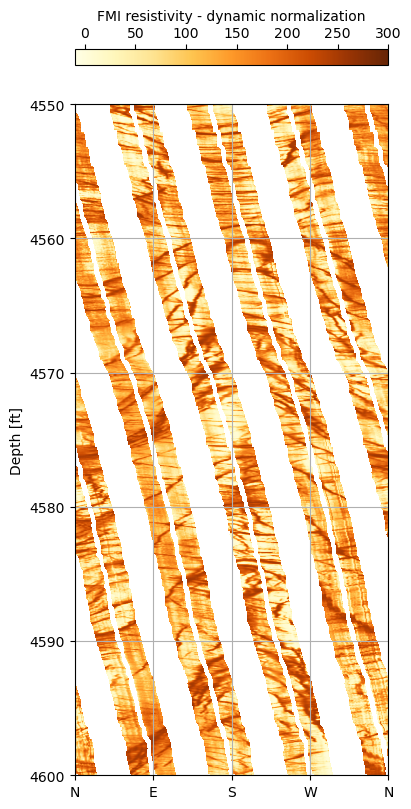

In [18]:
def paint_channel(ax, curve, y_axis, x_axis, **kwargs):
    """Plot an image channel into an axes using an index channel for the y-axis
    
    Parameters
    ----------
    
        ax : matplotlib.axes
        
        curve : numpy array
            The curve to be plotted
        
        index : numpy array 
            The depth index as a Channel object (slower) or a numpy array (faster)
        
        **kwargs : dict 
            Keyword arguments to be passed on to ax.imshow()
    """
    # Determine the extent of the image so that the pixel centres correspond with the correct axis values
    dx = np.mean(x_axis[1:] - x_axis[:-1])
    dy = np.mean(y_axis[1:] - y_axis[:-1])
    extent = (x_axis[0] - dx/2, x_axis[-1] + dx/2, y_axis[0] - dy/2, y_axis[-1] + dy/2)
    
    # Determine the correct orientation of the image
    if y_axis[1] < y_axis[0]:   # Frame recorded from the bottom to the top of the well
        origin = 'lower'
    else:                       # Frame recorded from the top to the bottom of the well
        origin = 'upper'
    
    return ax.imshow(curve, aspect='auto', origin=origin, extent=extent, **kwargs)


# Plot the image log
fig, ax = plt.subplots(1,1, figsize=(4,8), sharey=True, constrained_layout=True)

ang = np.arange(360)

im = paint_channel(ax, FMI_DYN, DEPT, ang, cmap='YlOrBr', vmin=-10, vmax=300) 

cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label('FMI resistivity - dynamic normalization')

ax.set_xticks([0, 90, 180, 270, 360])
ax.set_xticklabels(['N', 'E', 'S', 'W', 'N'])

ax.grid(True)

#ax.set_xlabel('Azimuthal angle from north [°]')
ax.set_ylabel('Depth [ft]')

ax.set_ylim(4600, 4550)

plt.show()
